In [138]:
import pandas as pd
import numpy as np

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

import matplotlib.pyplot as plt


In [8]:
df = pd.read_csv('Crypto')
df_rel = df[['open','volume','trade_count']]
df_rel.head()

,open,volume,trade_count
0,17112.80,0.973343,62.0
1,17114.07,0.785731,35.0
2,17118.52,1.396530,39.0
3,17117.41,1.790715,63.0
4,17108.82,1.210290,51.0


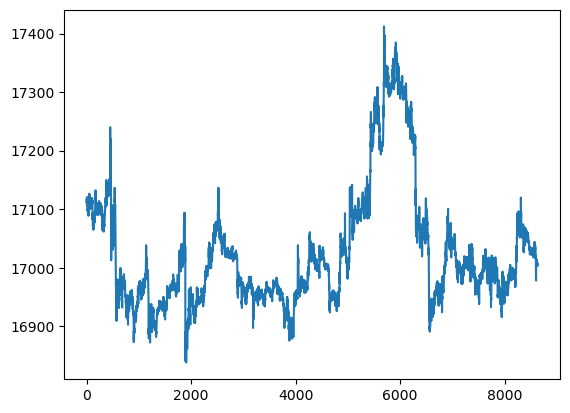

In [75]:
price_change = df_rel['open']
price_change.plot()
plt.show()

In [103]:
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset.values[i] - dataset.values[i - interval]
        diff.append(value)
    return diff

def scale(dataset):
    scaler = RobustScaler()
    scaled = scaler.fit_transform(dataset)
    return pd.DataFrame(scaled)

def add_lag(df, lag=1):
    columns = [df[0].shift(i) for i in range(1, lag+1)]
    columns.append(df)
    df = pd.concat(columns, axis=1)
    df = df.drop(0)
    df.columns=['open_t','open_t+1','volume_t', 'trade_count_t']
    return df

def split_data(df, test_size = 0.2):
    X = df.drop('open_t+1', axis=1).values
    Y = df['open_t+1'].values
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=42)
    X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
    X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

    return  X_train, X_test, y_train, y_test

def process_data(df):
    return split_data(add_lag(scale(difference(df))))


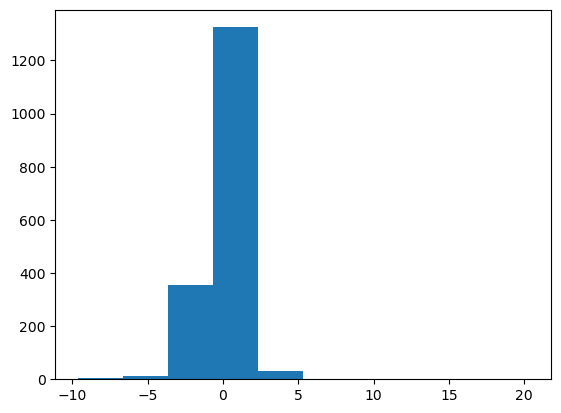

In [123]:
X_train, X_test, y_train, y_test = process_data(df_rel)

plt.hist(y_test)
plt.show()

Epoch 1/20
96/96 - 2s - loss: 0.7377 - val_loss: 0.7587 - 2s/epoch - 24ms/step
Epoch 2/20
96/96 - 0s - loss: 0.7366 - val_loss: 0.7592 - 405ms/epoch - 4ms/step
Epoch 3/20
96/96 - 0s - loss: 0.7356 - val_loss: 0.7595 - 392ms/epoch - 4ms/step
Epoch 4/20
96/96 - 0s - loss: 0.7349 - val_loss: 0.7596 - 402ms/epoch - 4ms/step
Epoch 5/20
96/96 - 0s - loss: 0.7344 - val_loss: 0.7597 - 451ms/epoch - 5ms/step
Epoch 6/20
96/96 - 0s - loss: 0.7342 - val_loss: 0.7597 - 439ms/epoch - 5ms/step
Epoch 7/20
96/96 - 0s - loss: 0.7338 - val_loss: 0.7599 - 422ms/epoch - 4ms/step
Epoch 8/20
96/96 - 0s - loss: 0.7336 - val_loss: 0.7603 - 449ms/epoch - 5ms/step
Epoch 9/20
96/96 - 0s - loss: 0.7335 - val_loss: 0.7601 - 413ms/epoch - 4ms/step
Epoch 10/20
96/96 - 0s - loss: 0.7332 - val_loss: 0.7602 - 412ms/epoch - 4ms/step
Epoch 11/20
96/96 - 0s - loss: 0.7330 - val_loss: 0.7599 - 426ms/epoch - 4ms/step
Epoch 12/20
96/96 - 0s - loss: 0.7329 - val_loss: 0.7601 - 443ms/epoch - 5ms/step
Epoch 13/20
96/96 - 0s - lo

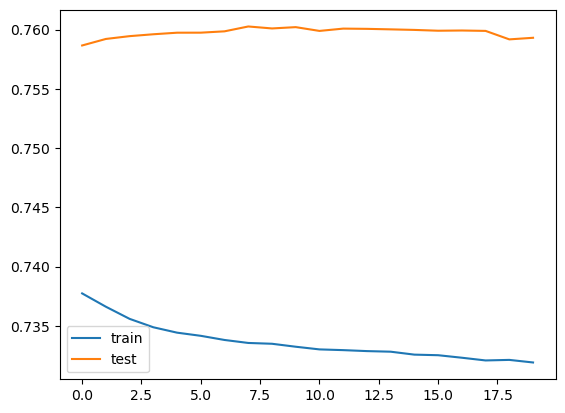

In [136]:


model = Sequential()
model.add(LSTM(100, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(X_train, y_train, epochs=20, batch_size=72, validation_data=(X_test, y_test), verbose=2, shuffle=False)
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [140]:
yhat = model.predict(X_test)

def direction_acc(yhat,y_test):
    return sum(y1 * y2 >= 0 for y1, y2 in zip(yhat, y_test))/len(yhat)

def count_close(yhat,y_test, margin = 0.05):
    return sum((abs(y1 - y2)) <= max(y_test)*margin for y1, y2 in zip(yhat, y_test))/len(yhat)

def rmse(yhat,y_test):
    return np.sqrt(mean_squared_error(yhat, y_test))


print(direction_acc(yhat, y_test)) 
print(count_close(yhat, y_test))
print(rmse(yhat, y_test))


54/54 [==============================] - 0s 2ms/step
[0.54519119]
[0.77520278]
1.2218073311731326
